In [1]:
# Import required libraries

from qiskit.circuit import QuantumCircuit, QuantumRegister, AncillaRegister, Gate
from qiskit.quantum_info import Statevector, Operator

import numpy as np

# 1D Ising Model Simulation on Quanumt Computer
The goal here is to simulate the 1D Ising Model on a Quatum Computer, i.e. we design a Quantum Circuit which performs a quantum simulation of the 1D Ising Hamiltonian and performs a measurement of the magnetization.
In addition we determine the ground state and ground state energy using the variational quantum eigensolver (VQE) algorithm. Using these results we find that the 1D Ising model has a quantum phase transition.

---
## Notebook Content
1. [**Theoretical Background**](#theory) 1D Ising Model and Quantum Hamiltonian Simulation
2. [**Implementation of Quantum Simulation**](#implementation) Implementation of quantum simulation using Trotter Algorithm and evaluation of magnetization in examples with $N=3,10$
3. [**Ground State and Ground State Energy**](#vqe) Implementation of VQE to find ground state and ground state energy and discussion of examples with $N=3,10$
---


# Theoretical Background
<a id='theory'></a>
## 1D Ising Model
The Ising model describes spin-spin interactions and was conceived as a model for ferromagnetism in statistical physics. It is one of the simplest, analytically solvable (for $D=1,2$) models which feature phase transitions. The 1D realization, which we consider here, does not have a thermal phase transition but a quantum phase transition, which we will study here. Quantum phase transition means that for a specific value of the external magnetic field the ground state and thus the magnetization abruptly jumps.

The Hamiltonian for the $1D$ model for $N$ spins $\vec{S}_i,\, i=0,\ldots ,N-1$ and a transverse magnetric field with magnitude $h$ (which we take to be in the $x$-direction) is given by
$$
H = -J \sum_{i=0}^{N-2} S_i^z S_{i+1}^z - h \sum_{i=0}^{N-1} S_i^x\,,
$$
where $S_i^z$ and $S_i^x$ are the spin projections in the $z$ and $x$ direction, respectively. $J$ is the interaction energy which we take to be $J=1$ in the following, i.e. $h$ is measured in units of $J$ and $t$ in units of $1/J$.

We can express this Hamiltonian in terms of Pauli matrices in order to turn it into an operator that can be acted on $N$ qubit states which model the spins $|s_0\cdots s_{N-1}\rangle$
$$
H = - \sum_{i=0}^{N-2} Z_i Z_{i+1} - h \sum_{i=0}^{N-1} X_i\,,
$$
where this notation means that the Pauli matrices $Z_i$ and $X_i$ are applied to the $i$-th qubit. A more accurate representation includes the tensor products with the identity matrices applied to the remaining spins. As an explicit example, let us consider $N=3$. In this case the Hamiltonian takes the explicit form
$$
H = -Z_1 \otimes Z_2 \otimes I  -  I \otimes Z_2 \otimes Z_3 - h\left( X_1\otimes I \otimes I + I \otimes X_2 \otimes I + I\otimes I \otimes X_3\right)\,,
$$
where $I$ is the identity matrix.

Finally, let us define the magnetization $M$ as the spin sum in the $z$ direction
$$
M = \frac{1}{N}\sum_{i=0}^{N-1} \langle S_i^z\rangle\,.
$$

## Quantum Hamiltonian Simulation
The time evoluation of a quantum state $|\psi\rangle$ under the Hamiltonian $H$ is given by the Schr\"odinger equation (setting $\hbar = 1$)
$$
\frac{d|\psi\rangle}{dt} = -i H |\psi\rangle\,.
$$
The solution to this is
$$
|\psi (t)\rangle = e^{-i H t} |\psi (0)\rangle\,.
$$
For a Hamiltonian that is a tensor product of Pauli matrices $H = \alpha\, \sigma_1 \otimes \sigma_2 \otimes \cdots \otimes \sigma_n$ this can easily be implemented through simple quantum gates. Via unitary operators we can diagonalize the Hamiltonian, i.e. we can express it in terms of the third Pauli matrix only, i.e.
$$
e^{-i t H} = (U_1 \otimes U_2 \otimes \cdots \otimes U_n) e^{-i\alpha t\, Z_1\otimes Z_2\otimes \cdots \otimes Z_n} (U_1^\dagger \otimes U_2^\dagger \otimes \cdots \otimes U_n^\dagger)\,,
$$
where $Z_i$ is the third Pauli matrix acting on the $i$-th qubit. Using that
$$
e^{-i\alpha t\, Z_1\otimes Z_2\otimes \cdots \otimes Z_n} |s_1 \cdots s_n\rangle = e^{-i\alpha t (-1)^{\oplus_i s_i}}|s_1 \cdots s_n\rangle\,,
$$
this can be implemented by constructing $s_1 \oplus s_2 \oplus \cdots \oplus s_n$ in the last qubit with CNOT gates, followed by a $R_z(-\alpha t)$ rotation on the last qubit and the same sequence of CNOT gates in the reverse order to restore the initial state. If the sequence of Pauli matrices contains an identity, the qubit that the identity acts on can simply be ignored. The $U_i$ are easily found using the identities
$$
Y = S H Z H^\dagger S^\dagger\,,\quad X = H Z H^\dagger\,.
$$
As a last step, let us discuss how to simulate Hamiltonians which are a sum of terms of tensor products of Pauli matrices $H= \sum_{i=1}^p H_i$. In that case we can use the Suzuki-Trotter decomposition
$$
e^{-it H} = \left( \prod_{i=1}^m e^{-it H_i / p} \right)^p + \mathcal{O}\left(\frac{(\nu t)^2}{p}\right)\,,
$$
where $\nu = \max_j \{||H_j||\}$.

# Implementation
<a id='implementation'></a>
We implement $e^{-it H_1}$ and $e^{-i t H_2}$ independently since each term in $H_1$ and $H_2$ commute. $H_1$ and $H_2$ are defined as
$$
H = H_1 + H_2\quad\text{with}\quad H_1 = - \sum_{i=0}^{N-2} Z_i Z_{i+1} \quad \text{and} \quad H_2 = - h \sum_{i=0}^{N-1} X_i\,.
$$
Finally we implement the Suzuki-Trotter decomposition.

In [2]:
def ExpH1(t: float, N: int) -> QuantumCircuit:
    """
    Implementation of the free Hamiltonian evolution exp(-it H1)

    Args:
        t (float): simulation time
        N (int):   number of spins (qubits)
    
    Returns:
        QuantumCircuit: QuantumCircuit object which contains the circuit for the free Hamiltonian evolution
    """
    Qnt_reg = QuantumRegister(size=N, name="S")

    ExpH1_circ =QuantumCircuit(Qnt_reg, name="exp(-it H1)")

    for i in range(len(Qnt_reg)-1):
        ExpH1_circ.cx(Qnt_reg[i],Qnt_reg[i+1])
        ExpH1_circ.rz(-2*t,Qnt_reg[i+1])
        ExpH1_circ.cx(Qnt_reg[i],Qnt_reg[i+1])
        ExpH1_circ.barrier()

    return ExpH1_circ

def ExpH2(t: float, h: float, N: int) -> QuantumCircuit:
    """
    Implementation of the interaction Hamiltonian evolution exp(-it H2)

    Args:
        t (float): simulation time
        h (float): magnetic field magnitude
        N (int):   number of spins (qubits)
    
    Returns:
        QuantumCircuit: QuantumCircuit object which contains the circuit for the interaction Hamiltonian evolution
    """
    Qnt_reg = QuantumRegister(size=N, name="S")

    ExpH2_circ =QuantumCircuit(Qnt_reg, name="exp(-it H2)")

    for q in Qnt_reg:
        ExpH2_circ.h(q)
        ExpH2_circ.rz(-2*h*t, q)
        ExpH2_circ.h(q)
        ExpH2_circ.barrier()

    return ExpH2_circ

def TrotterIsing(t: float, h: float, N: int, k: int) -> QuantumCircuit:
    """
    Implementation of the time evolution operator using the Trotter algorithm

    Args:
        t (float): simulation time
        h (float): magnetic field magnitude
        N (int):   number of spins (qubits)
        k (int):   order in Trotter expansion
    
    Returns:
        QuantumCircuit: QuantumCircuit object which contains the circuit for the Ising model time evolution
    """
    Qnt_reg = QuantumRegister(size=N, name="S")

    Trotter_circ =QuantumCircuit(Qnt_reg, name="exp(-it H)")

    for i in range(k):
        Trotter_circ.compose(ExpH1(t/k, N), inplace=True)
        Trotter_circ.compose(ExpH2(t/k, h, N), inplace=True)

    return Trotter_circ

## N=3 Ising Model
Let us now check $N=3$ explicitly and let us compare it to the exact result for different values of the . We start with a visualization of the circuits and then compare the simulation results for different values of the Trotter factor.

Circuit for $e^{-i t H_1}$

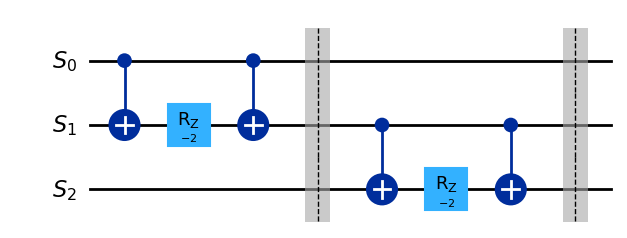

In [55]:
ExpH1(1, 3).draw(output="mpl")

Circuit for $e^{-i t H_2}$

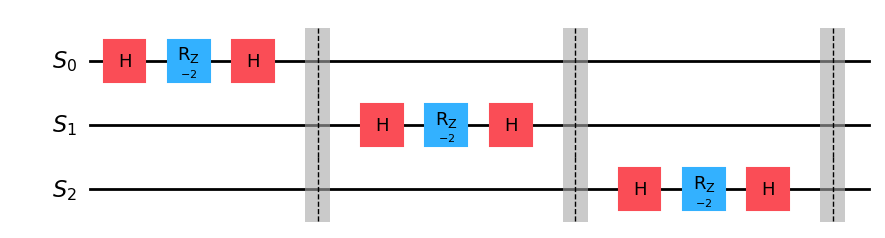

In [56]:
ExpH2(1, 1, 3).draw(output="mpl")

The full time evolution $e^{-i t H}$ in the second order Trotter expansion $e^{-i t H} = \left(e^{-it H_1/2} e^{-it H_2/2} \right)^2 + \mathcal{O}\left(2^3 \left(\frac{t}{2}\right)^2\right)$

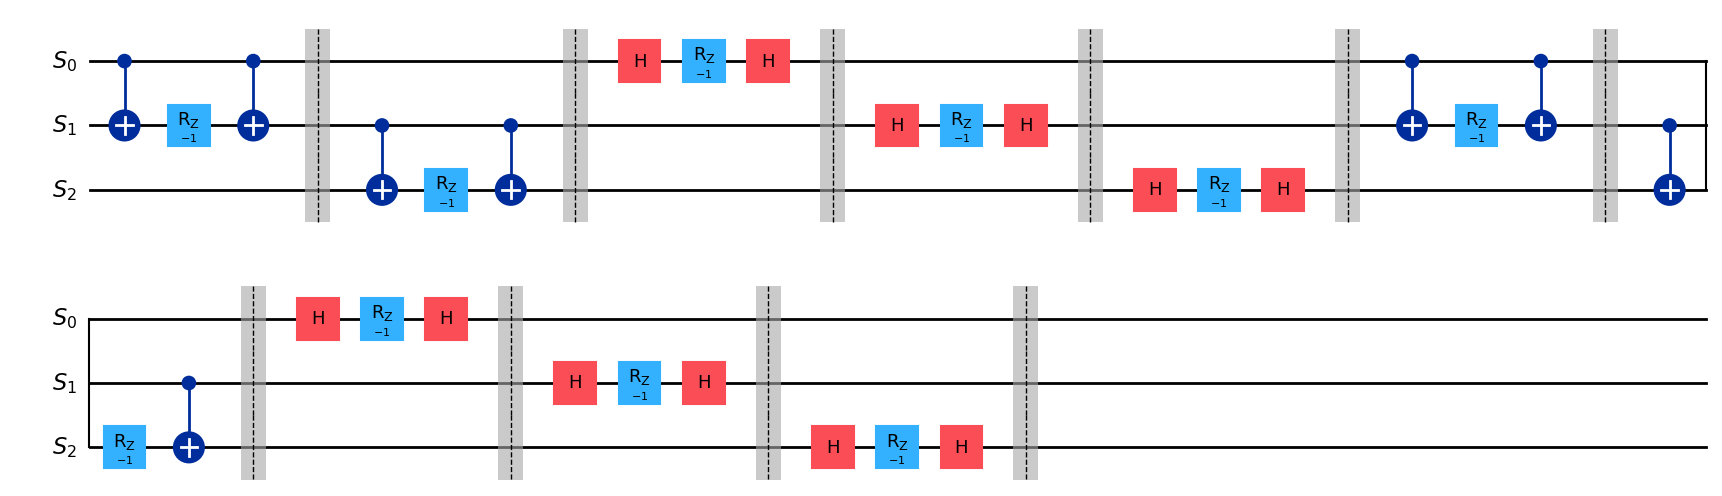

In [57]:
TrotterIsing(1, 1, 3, 2).draw(output="mpl")

We want to compare to the exact, i.e. numeric results. For this reason we implement the full Hamiltonian, using Kroneker products of the Pauli gates

In [3]:
# Analytic Computation
import scipy

def AnalyticHamiltonian(h: float, N: int) -> np.array:
    """
    Implementation of the analytic Hamiltonian H

    Args:
        h (float): magnetic field magnitude
        N (int):   number of spins (qubits)
    
    Returns:
        np.array: Hamiltonian matrix as np.array object
    """

    # initialize Hamiltonian to zeros
    ham = np.zeros((2**N,2**N))
    
    # construct H1
    for i in range(N-1):
        if i == 0:
            curr = np.array([[1, 0], [0, -1]])
        else:
            curr = np.eye(2)
        for _ in range(1, i):
            curr = np.kron(curr, np.eye(2))
        if i > 0:
            curr = np.kron(curr, np.array([[1, 0], [0, -1]]))
        curr = np.kron(curr, np.array([[1, 0], [0, -1]]))
        for _ in range(i+2,N):
            curr = np.kron(curr, np.eye(2))

        ham += -curr
    
    # add H2 to it
    for i in range(N):
        if i==0:
            curr = np.array([[0, 1], [1, 0]])
        else:
            curr = np.eye(2)
        
        for _ in range(1,i):
            curr = np.kron(curr, np.eye(2))
        
        if i > 0:
            curr = np.kron(curr,  np.array([[0, 1], [1, 0]]))
        
        for _ in range(i+1, N):
            curr = np.kron(curr, np.eye(2))
        
        ham += -h*curr
    
    return ham

Let us now compute the time evolution, starting from the state $|000\rangle$ using the exact time evolution operator $e^{-it H}$

In [16]:
HN3 = AnalyticHamiltonian(1, 3)
init = np.zeros(2**3)
init[0] = 1
expH  = scipy.linalg.expm(-1j * HN3 * 0.1)
vec    = expH @ init
vec    = vec / vec[0] # global phase
cvec   = vec / np.linalg.norm(vec) # normalize
cvecprob = np.abs(cvec)**2
print(f"Hamiltonian: \n{HN3}\nInitial state: \n|000>={init}\nExp(-iHt)=\n{np.round(expH,3)}\nResulting state after t=0.5: {np.round(cvec,3)}")
print(f"Probabilities: {np.round(np.abs(cvec)**2,3)}")

Hamiltonian: 
[[-2. -1. -1.  0. -1.  0.  0.  0.]
 [-1.  0.  0. -1.  0. -1.  0.  0.]
 [-1.  0.  2. -1.  0.  0. -1.  0.]
 [ 0. -1. -1.  0.  0.  0.  0. -1.]
 [-1.  0.  0.  0.  0. -1. -1.  0.]
 [ 0. -1.  0.  0. -1.  2.  0. -1.]
 [ 0.  0. -1.  0. -1.  0.  0. -1.]
 [ 0.  0.  0. -1.  0. -1. -1. -2.]]
Initial state: 
|000>=[1. 0. 0. 0. 0. 0. 0. 0.]
Exp(-iHt)=
[[ 0.965+0.197j -0.01 +0.098j -0.   +0.098j -0.01 -0.j    -0.01 +0.098j
  -0.01 -0.j    -0.01 -0.j     0.   -0.001j]
 [-0.01 +0.098j  0.985-0.j    -0.01 +0.j     0.   +0.099j -0.01 -0.j
   0.01 +0.098j  0.   -0.001j -0.01 -0.j   ]
 [ 0.   +0.098j -0.01 +0.j     0.965-0.197j  0.01 +0.098j -0.01 +0.j
  -0.   -0.001j  0.01 +0.098j -0.01 -0.j   ]
 [-0.01 -0.j     0.   +0.099j  0.01 +0.098j  0.985-0.j     0.   -0.001j
  -0.01 +0.j    -0.01 -0.j    -0.01 +0.098j]
 [-0.01 +0.098j -0.01 -0.j    -0.01 +0.j     0.   -0.001j  0.985-0.j
   0.01 +0.098j  0.   +0.099j -0.01 -0.j   ]
 [-0.01 -0.j     0.01 +0.098j -0.   -0.001j -0.01 +0.j     0.01 +0.098

Extract the Magnetization and Spin Projections of individual spins from the final state vector

In [17]:
def StateToSpin(probVec: np.array, numSpins: int) -> dict:
    """
    Transform statevector probabilities to spin configuration with probabilities
    
    Args:
        probVec (np.array): vector of probabilities for each basis element
        numSpins (int):     total number of spins on chain
    
    Returns:
        dict: dictionary in the form spin-configuration: probabilitiy, i.e. {[0,0,...,0]: 0.9, ...}
    """
    spinDict = {}
    for i, prob in enumerate(probVec):
        spinDict[tuple((i >> np.arange(numSpins))%2)] = prob
    
    return spinDict

def Magnetization(SpinDict: dict, numSpins: int) -> float:
    """
    Computes the mangetization (probability weighted sum of spins) for the Ising Model
    
    Args:
        SpinDict (dict):    dictionary that contains the spin configuration as a tuple as key and the corresponding probability as value
        numSpins (int):     total number of spins on chain
    
    Returns:
        float: magnetization
    """
    magn = 0
    for spins, prob in SpinDict.items():
        magn += np.abs(prob*(numSpins - 2*sum(spins)))
    
    return magn/numSpins

def ProbSpinUp(SpinDict: dict, SpinIndex: int) -> float:
    """
    Computes the probability that a given spin with index SpinIndex is in the up position (0)
    
    Args:
        SpinDict (dict):    dictionary that contains the spin configuration as a tuple as key and the corresponding probability as value
        numSpins (int):     total number of spins on chain
    
    Returns:
        float: probability that the spin with index SpinIndex has a positive projection along the z-axis, i.e. it isencoded by a 0
    """
    probUp = 0
    for spins, prob in SpinDict.items():
        if spins[SpinIndex] == 0:
            probUp += prob
    
    return probUp

Now we compute the magnetization as a function of time for various Trotterization parameters and compare the results to the exact time evolution. The magnetization is the expectation value of the operator $M = \sum_{i=1}^{N} Z_i$, where $Z_i$ acts on the $i$-th qubit each term has tensor products of the identity operator on all other qubits. The expectation value is given by
$$
\langle M\rangle = \langle \psi (t) | M | \psi(t)\rangle = \langle \psi(0)| e^{i H t} M e^{-i H t} | \psi(0)\rangle\,.
$$
Since $M$ is diagonal in the computational basis/spin basis, we can simply evovle the initial state and compute the expectation value by projecting the final state on the spin basis and evaluating $Z_i$ on the spin states. In order to make this clearer, let us show the computation for $N=2$ explicitly
$$
\langle \psi (t) | M | \psi(t) \rangle = \frac{1}{2}\langle \psi (t) | Z_0 \otimes I |  \psi(t) \rangle + \frac{1}{2}\langle \psi (t) | I \otimes Z_1 |  \psi(t) \rangle = \frac{1}{2}\sum_{i,j=0,1} \langle \psi (t) | i j\rangle \langle i j| Z_0 \otimes I | i j\rangle \langle i j| \psi(t)\rangle + \frac{1}{2}\sum_{i,j=0,1} \langle \psi (t) | i j\rangle \langle i j| I \otimes Z_1 | i j\rangle \langle i j| \psi(t)\rangle\\
= 1\cdot |\langle 00 | \psi (t)\rangle|^2 + 0\cdot |\langle 01 | \psi (t)\rangle|^2 + 0\cdot |\langle 10 | \psi (t)\rangle|^2 - 1\cdot |\langle 11 | \psi (t)\rangle|^2\,,
$$
where we used that the operator is diagonal when inserting a full set of states.

In the following we will often use the magnitude of the magnetization $|M|$, which in the previous example is given by
$$
\langle \psi (t) |\, |M|\, | \psi(t) \rangle = = 1\cdot |\langle 00 | \psi (t)\rangle|^2 + 0\cdot |\langle 01 | \psi (t)\rangle|^2 + 0\cdot |\langle 10 | \psi (t)\rangle|^2 + 1\cdot |\langle 11 | \psi (t)\rangle|^2\,.
$$

In [18]:
from tqdm import tqdm
# find exact result
N = 3
h = 5
tmax = 4
tstep = 0.05
magn_exact = []
magn_1 = []
magn_10 = []
magn_50 = []
HN3 = AnalyticHamiltonian(h, N)
init = np.zeros(2**N)
init[0] = 1

for t in tqdm(np.arange(0, tmax, tstep)):
    expH  = scipy.linalg.expm(-1j * HN3 * t)
    vec    = expH @ init
    vec    = vec / vec[0] # global phase
    cvec   = vec / np.linalg.norm(vec) # normalize
    cvecprob = np.abs(cvec)**2
    spinDict_exact = StateToSpin(cvecprob, N)
    magn_exact.append([t, Magnetization(spinDict_exact, N)])

for t in tqdm(np.arange(0, tmax, tstep)):
    Ising1 = TrotterIsing(t, h, N, 1)
    res1 = Statevector(Ising1).probabilities()
    spinDict_1 = StateToSpin(res1, N)
    magn_1.append([t, Magnetization(spinDict_1, N)])

for t in tqdm(np.arange(0, tmax, tstep)):
    Ising10 = TrotterIsing(t, h, N, 10)
    res10 = Statevector(Ising10).probabilities()
    spinDict_10 = StateToSpin(res10, N)
    magn_10.append([t, Magnetization(spinDict_10, N)])

for t in tqdm(np.arange(0, tmax, tstep)):
    Ising50 = TrotterIsing(t, h, N, 50)
    res50 = Statevector(Ising50).probabilities()
    spinDict_50 = StateToSpin(res50, N)
    magn_50.append([t, Magnetization(spinDict_50, N)])


100%|██████████| 80/80 [00:01<00:00, 69.72it/s]


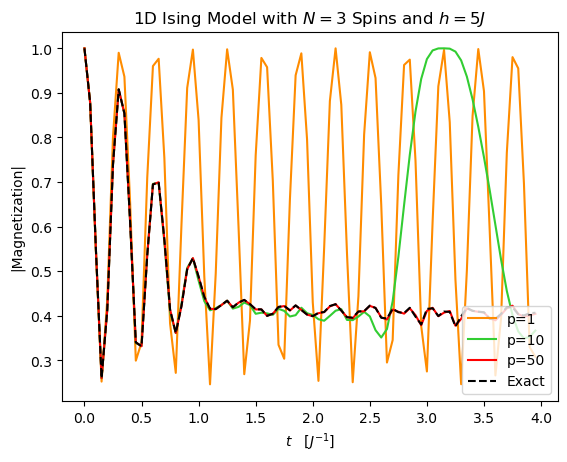

In [88]:
import matplotlib.pyplot as plt

plt.plot([x[0] for x in magn_1], [x[1] for x in magn_1], c="darkorange", ls="-", label="p=1")
plt.plot([x[0] for x in magn_10], [x[1] for x in magn_10], c="limegreen", ls="-", label="p=10")
plt.plot([x[0] for x in magn_50], [x[1] for x in magn_50], c="red", ls="-", label="p=50")
plt.plot([x[0] for x in magn_exact], [x[1] for x in magn_exact], c="k", ls="--", label="Exact")
plt.xlabel(r'$t$   $[J^{-1}]$')
plt.ylabel("|Magnetization|")
plt.legend(loc="lower right")
plt.title("1D Ising Model with $N=3$ Spins and $h=5J$")
plt.savefig("Magnetization_vs_t_N3.png", dpi=300, bbox_inches='tight')

Now let us consider the operator error

In [20]:
from tqdm import tqdm
# find exact result
N = 3
h = 5
tmax = 4
tstep = 0.05
error_3_1 = []
error_3_10 = []
error_3_50 = []
HN3 = AnalyticHamiltonian(h, N)
init = np.zeros(2**N)
init[0] = 1

nu = max(np.linalg.svdvals(Operator(ExpH1(1, N)).data)[0], np.linalg.svdvals(Operator(ExpH2(1, h, N)).data)[0])
print(nu)

for t in tqdm(np.arange(0, tmax, tstep)):
    expH  = scipy.linalg.expm(-1j * HN3 * t)
    IsingH1 = Operator(TrotterIsing(t, h, N, 1)).data
    error_3_1.append([t, np.linalg.svdvals(expH - IsingH1)[0]])

for t in tqdm(np.arange(0, tmax, tstep)):
    expH  = scipy.linalg.expm(-1j * HN3 * t)
    IsingH10 = Operator(TrotterIsing(t, h, N, 10)).data
    error_3_10.append([t,  np.linalg.svdvals(expH - IsingH10)[0]])

for t in tqdm(np.arange(0, tmax, tstep)):
    expH  = scipy.linalg.expm(-1j * HN3 * t)
    IsingH50 = Operator(TrotterIsing(t, h, N, 50)).data
    error_3_50.append([t, np.linalg.svdvals(expH - IsingH50)[0]])

1.0


100%|██████████| 80/80 [00:02<00:00, 34.99it/s]


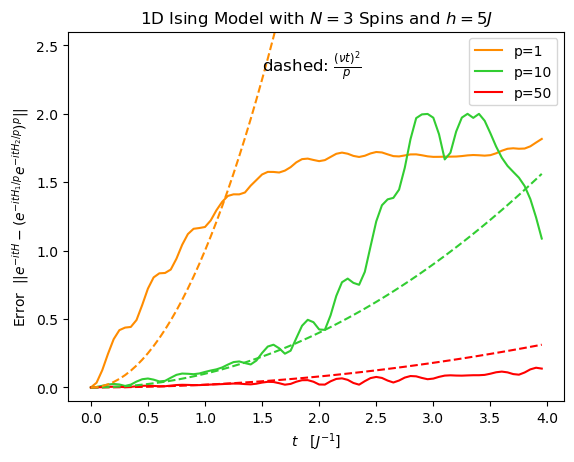

In [89]:
plt.plot([x[0] for x in error_3_1], [x[1] for x in error_3_1], c="darkorange", ls="-", label="p=1")
plt.plot([x[0] for x in error_3_10], [x[1] for x in error_3_10], c="limegreen", ls="-", label="p=10")
plt.plot([x[0] for x in error_3_50], [x[1] for x in error_3_50], c="red", ls="-", label="p=50")
plt.plot([x[0] for x in error_3_50], [(nu*x[0])**2/50 for x in error_3_50], c="red", ls="--")
plt.plot([x[0] for x in error_3_10], [(nu*x[0])**2/10 for x in error_3_10], c="limegreen", ls="--")
plt.plot([x[0] for x in error_3_1], [(nu*x[0]/1)**2 for x in error_3_1], c="darkorange", ls="--")
plt.ylim(-0.1,2.6)
plt.xlabel('$t$   $[J^{-1}]$')
plt.ylabel("Error  $||e^{-it H} - (e^{-it H_1/p}e^{-it H_2/p})^p||$")
plt.text(1.5, 2.3, r'dashed: $\frac{(\nu t)^2}{p}$', fontsize='large')
plt.legend(loc="upper right")
plt.title("1D Ising Model with $N=3$ Spins and $h=5J$")
plt.savefig("Error_vs_t_N3.png", dpi=300, bbox_inches='tight')

The exact operator error roughly follows the error estimate. It is also clearly visible that a larger value of $p$ reduces the error.

## N=10
Now let us do the same for $N=10$ spins with the same parameters

In [22]:
from tqdm import tqdm
# find exact result
N = 10
h = 5
tmax = 4
tstep = 0.05
magn_exact = []
magn_1 = []
magn_10 = []
magn_50 = []
HN3 = AnalyticHamiltonian(h, N)
init = np.zeros(2**N)
init[0] = 1

nu10 = max(np.linalg.svdvals(Operator(ExpH1(1, N)).data)[0], np.linalg.svdvals(Operator(ExpH2(1, h, N)).data)[0])
print(nu10)

for t in tqdm(np.arange(0, tmax, tstep)):
    expH  = scipy.linalg.expm(-1j * HN3 * t)
    vec    = expH @ init
    vec    = vec / vec[0] # global phase
    cvec   = vec / np.linalg.norm(vec) # normalize
    cvecprob = np.abs(cvec)**2
    spinDict_exact = StateToSpin(cvecprob, N)
    magn_exact.append([t, Magnetization(spinDict_exact, N)])

for t in tqdm(np.arange(0, tmax, tstep)):
    Ising1 = TrotterIsing(t, h, N, 1)
    res1 = Statevector(Ising1).probabilities()
    spinDict_1 = StateToSpin(res1, N)
    magn_1.append([t, Magnetization(spinDict_1, N)])

for t in tqdm(np.arange(0, tmax, tstep)):
    Ising10 = TrotterIsing(t, h, N, 10)
    res10 = Statevector(Ising10).probabilities()
    spinDict_10 = StateToSpin(res10, N)
    magn_10.append([t, Magnetization(spinDict_10, N)])

for t in tqdm(np.arange(0, tmax, tstep)):
    Ising50 = TrotterIsing(t, h, N, 50)
    res50 = Statevector(Ising50).probabilities()
    spinDict_50 = StateToSpin(res50, N)
    magn_50.append([t, Magnetization(spinDict_50, N)])

1.0000000000000022


100%|██████████| 80/80 [00:04<00:00, 17.12it/s]


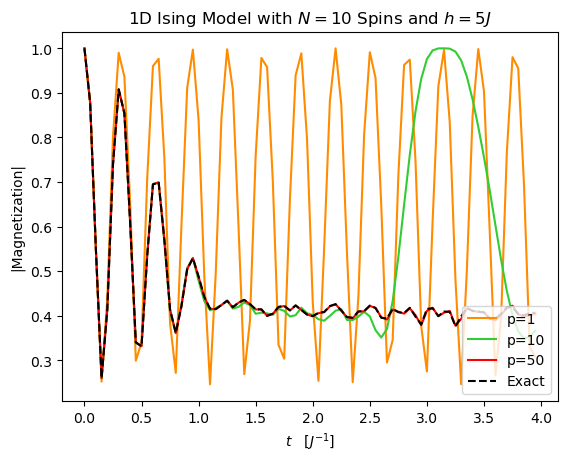

In [90]:
plt.plot([x[0] for x in magn_1], [x[1] for x in magn_1], c="darkorange", ls="-", label="p=1")
plt.plot([x[0] for x in magn_10], [x[1] for x in magn_10], c="limegreen", ls="-", label="p=10")
plt.plot([x[0] for x in magn_50], [x[1] for x in magn_50], c="red", ls="-", label="p=50")
plt.plot([x[0] for x in magn_exact], [x[1] for x in magn_exact], c="k", ls="--", label="Exact")
plt.xlabel(r'$t$   $[J^{-1}]$')
plt.ylabel("|Magnetization|")
plt.legend(loc="lower right")
plt.title("1D Ising Model with $N=10$ Spins and $h=5J$")
plt.savefig("Magnetization_vs_t_N10.png", dpi=300, bbox_inches='tight')

In [92]:
from tqdm import tqdm
# find exact result
N = 10
h = 5
tmax = 4
tstep = 0.05
error_1 = []
error_10 = []
error_50 = []
HN3 = AnalyticHamiltonian(h, N)
init = np.zeros(2**N)
init[0] = 1

for t in tqdm(np.arange(0, tmax, tstep)):
    expH  = scipy.linalg.expm(-1j * HN3 * t)
    IsingH1 = Operator(TrotterIsing(t, h, N, 1)).data
    error_1.append([t, np.linalg.svdvals(expH - IsingH1)[0]])

for t in tqdm(np.arange(0, tmax, tstep)):
    expH  = scipy.linalg.expm(-1j * HN3 * t)
    IsingH10 = Operator(TrotterIsing(t, h, N, 10)).data
    error_10.append([t,  np.linalg.svdvals(expH - IsingH10)[0]])

for t in tqdm(np.arange(0, tmax, tstep)):
    expH  = scipy.linalg.expm(-1j * HN3 * t)
    IsingH50 = Operator(TrotterIsing(t, h, N, 50)).data
    error_50.append([t, np.linalg.svdvals(expH - IsingH50)[0]])

100%|██████████| 80/80 [32:20<00:00, 24.25s/it]


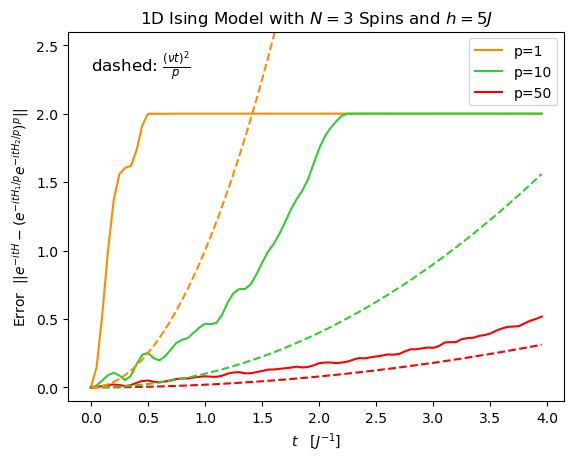

In [93]:
plt.plot([x[0] for x in error_1], [x[1] for x in error_1], c="darkorange", ls="-", label="p=1")
plt.plot([x[0] for x in error_10], [x[1] for x in error_10], c="limegreen", ls="-", label="p=10")
plt.plot([x[0] for x in error_50], [x[1] for x in error_50], c="red", ls="-", label="p=50")
plt.plot([x[0] for x in error_50], [(nu10*x[0])**2/50 for x in error_50], c="red", ls="--")
plt.plot([x[0] for x in error_10], [(nu10*x[0])**2/10 for x in error_10], c="limegreen", ls="--")
plt.plot([x[0] for x in error_1], [(nu10*x[0]/1)**2 for x in error_1], c="darkorange", ls="--")
plt.ylim(-0.1,2.6)
plt.xlabel('$t$   $[J^{-1}]$')
plt.ylabel("Error  $||e^{-it H} - (e^{-it H_1/p}e^{-it H_2/p})^p||$")
plt.text(0, 2.3, r'dashed: $\frac{(\nu t)^2}{p}$', fontsize='large')
plt.legend(loc="upper right")
plt.title("1D Ising Model with $N=3$ Spins and $h=5J$")
plt.savefig("Error_vs_t_N10.png", dpi=300, bbox_inches='tight')

The exact operator error roughly follows the error estimate. However, the actual errors are typically larger than the simple estimates. Also note that the magnitude of the singular values of a unitary matrix is bound by $1$, which is the reason why the error flattens out at $2$.

# Ground State and Ground State Energy
<a id='vqe'></a>
As a last step we would like to determine both the ground state and its energy. For this we implement a simple version of a Variational Quantum Eigensolver (VQE). The VQE is a semi-classical algorithm, which consists of a quantum circuit, which prepares a tunable initial state $|\psi (\theta )\rangle$ with parameters $\theta$ and determines the expectation value of the Hamiltonian $\langle \psi (\theta) | H | \psi (\theta)\rangle$, i.e. the energy. The classical part of the algorithm consists of an optimizer which adjusts the tunable parameters in the state preparation such as to minimize the energy. In summary, the steps in the VQE algorithm are
1. Prepare sufficiently general state $|\psi (\theta)\rangle = U(\theta) |0\rangle$ with as little parameters $\theta$ as possible
2. Find the expectation $\langle \psi (\theta) | H | \psi (\theta)\rangle = \langle 0 | U^\dagger(\theta) H U(\theta) | 0\rangle$
3. Use a classical optimization algorithm to update the parameters $\theta$ in order to minimize the energy

An important part of the algorithm is to pick an ansatz, which is general enough to encompass a good approximation of the ground state, but at the same time has as little parameters as possible. We are going to use the pre-implemented ``efficient_su2`` which consists of $SU(2)$ operations on all qubits and ``CNOT`` gates to entangle them.

In order to find the expectation values of $Z_i Z_{i+1}$ we can use the observation that 
$$
Z_0 \otimes Z_1 |00\rangle = +1 |00\rangle\,, \quad Z_0 \otimes Z_1 |11\rangle = +1 |11\rangle\,,\quad Z_0 \otimes Z_1 |01\rangle = -1 |01\rangle\,, \quad Z_0 \otimes Z_1 |10\rangle = -1 |10\rangle\,,
$$
i.e. when both qubits have the same value ($00$ or $11$) the eigenvalue is $+1$ and if they have different values, the eigenvalue is $-1$. Thus we can implement this by using 2 ``CNOT`` gates which prepare an ancilla into the state $|q_1 \oplus q_2\rangle$, which corresponds to the eigenvalue $+1$ if $|q_1 \oplus q_2\rangle = |0\rangle$ and to the eigenvalue $-1$ if $|q_1 \oplus q_2\rangle = |1\rangle$.
For the expectation value of $X_i$ we use the identity $X_i = H Z_i H^\dagger$, i.e. we apply an $H$ gate on qubit $i$, measure it and a measurement of $|0\rangle$ corresponds to an eigenvalue of $+1$ and $|1\rangle$ to an eigenvalue of $-1$.
We can use this approach term by term in the Hamiltonian.

In [ ]:
from scipy.optimize import minimize

def calc_energy(ansatz: QuantumCircuit, h: float, N: int) -> float:
    """
    Computes the energy using a series of quantum circuits that measure the expectation value of the Hamiltonian

    Args:
        ansatz (QuantumCircuit): Quantum circuit object that prepares the initial state
        h (float): magnetic field magnitude
        N (int):   number of spins (qubits)
    
    Returns:
        float: energy, i.e. expectation value of Hamiltonian with state prepared by ansatz
    """
    en = 0

    # loop through the Z_i Z_i+1 part of the Hamiltonian, generate a quantum circuit which measures 
    # the expectation value of Z_i Z_i+1 in an ancilla qubit
    for i in range(N-1):
        Qnt_reg = QuantumRegister(size=N, name="S")
        exp_val = AncillaRegister(size=1, name="E")

        H1_circ = QuantumCircuit(Qnt_reg, exp_val, name="H1 expectation")
        H1_circ.compose(ansatz, qubits=Qnt_reg, inplace=True)
        H1_circ.barrier()
        H1_circ.cx(Qnt_reg[i],exp_val[0])
        H1_circ.cx(Qnt_reg[i+1],exp_val[0])
        
        H1state_vec = Statevector(H1_circ).probabilities()
        H1Spin_dict = StateToSpin(H1state_vec, N+1)
        prob0 = 0
        for spins, prob in H1Spin_dict.items():
            if spins[-1] == 0:
                prob0 += prob
        
        en -= prob0 - (1-prob0)
    
    # loop through the X_i part of the Hamiltonian, generate a quantum circuit which measures 
    # the expectation value of X_i in an ancilla qubit by turning it into the spin basis through the identity X = H Z H^\dagger
    for i in range(N):
        Qnt_reg = QuantumRegister(size=N, name="S")
        exp_val = AncillaRegister(size=1, name="E")

        H2_circ = QuantumCircuit(Qnt_reg, exp_val, name="H2 expectation")
        H2_circ.compose(ansatz, qubits=Qnt_reg, inplace=True)
        H2_circ.h(Qnt_reg[i])
        H2_circ.cx(Qnt_reg[i],exp_val[0])
        
        H2state_vec = Statevector(H2_circ).probabilities()
        H2Spin_dict = StateToSpin(H2state_vec, N+1)
        prob0 = 0
        for spins, prob in H2Spin_dict.items():
            if spins[-1] == 0:
                prob0 += prob
        
        en -= h*(prob0 - (1-prob0))
    
    return en

def VQE(ansatz: QuantumCircuit, h: float, N: int) -> list:
    """
    Performs VQE with given ansatz

    Args:
        ansatz (QuantumCircuit): Quantum circuit object that prepares the initial state
        h (float): magnetic field magnitude
        N (int):   number of spins (qubits)
    
    Returns:
        list: ground state energy and ground state vector [en, [a, b, c,...]]
    """
    # define function to minimize
    func = lambda param: calc_energy(ansatz.assign_parameters(param), h, N)

    # parameters between 0 and pi with random initial guess
    num_params = len(ansatz.parameters)
    initial_guess = np.pi*np.random.rand(num_params)
    bnds = tuple([(0,np.pi) for p in range(num_params)])
    res = minimize(func, initial_guess, bounds=bnds)

    energy = func(res.x)
    state = Statevector(ansatz.assign_parameters(res.x))

    magn = Magnetization(StateToSpin(state.probabilities(), N), N)

    return energy, magn, state

Now we compute the magnetization and energy for $N=3,10$ by computing the eigenvalues and eigenvectors of the hamiltonian numerically and using our implementation of the VQE.

In [83]:
from qiskit.circuit.library import efficient_su2

mag_exact_N3 = []
mag_exact_N10 = []
energy_exact_N3 = []
energy_exact_N10 = []
mag_VQE_N3 = []
mag_VQE_N10 = []
energy_VQE_N3 = []
energy_VQE_N10 = []
hvals = np.linspace(0,3,30)
hvalsQu = np.linspace(0,3,10)

for h in tqdm(hvals):
    Ham3 = AnalyticHamiltonian(h, 3)
    Ham10 = AnalyticHamiltonian(h, 10)
    e_vals_3, e_vecs_3 = np.linalg.eigh(Ham3)
    e_vals_10, e_vecs_10 = np.linalg.eigh(Ham10)
    spinDict_exact_3 = StateToSpin(e_vecs_3[:,0]**2, 3)
    spinDict_exact_10 = StateToSpin(e_vecs_10[:,0]**2, 10)
    energy_exact_N3.append(e_vals_3[0])
    energy_exact_N10.append(e_vals_10[0])
    mag_exact_N3.append(Magnetization(spinDict_exact_3, 3))
    mag_exact_N10.append(Magnetization(spinDict_exact_10, 10))

for h in tqdm(hvalsQu):
    ansatz = efficient_su2(3, entanglement='linear',reps=1)
    en, magn, state = VQE(ansatz, h, 3)
    mag_VQE_N3.append(magn)
    energy_VQE_N3.append(en)

for h in tqdm(hvalsQu):
    ansatz = efficient_su2(10, entanglement='linear',reps=1)
    en, magn, state = VQE(ansatz, h, 10)
    mag_VQE_N10.append(magn)
    energy_VQE_N10.append(en)

100%|██████████| 10/10 [30:46<00:00, 184.65s/it]


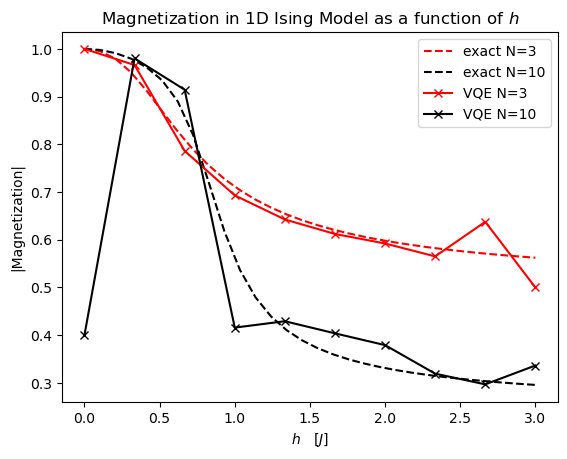

In [85]:
plt.plot(hvals, mag_exact_N3, c="red", ls="--", label="exact N=3")
plt.plot(hvals, mag_exact_N10, c="black", ls="--", label="exact N=10")
plt.plot(hvalsQu, mag_VQE_N3, c="red", marker="x", ls="-", label="VQE N=3")
plt.plot(hvalsQu, mag_VQE_N10, c="black",  marker="x", ls="-", label="VQE N=10")
plt.xlabel(r'$h$   $[J]$')
plt.ylabel("|Magnetization|")
plt.legend(loc="upper right")
plt.title("Magnetization in 1D Ising Model as a function of $h$")
plt.savefig("Magnetization_vs_h.png", dpi=300, bbox_inches='tight')

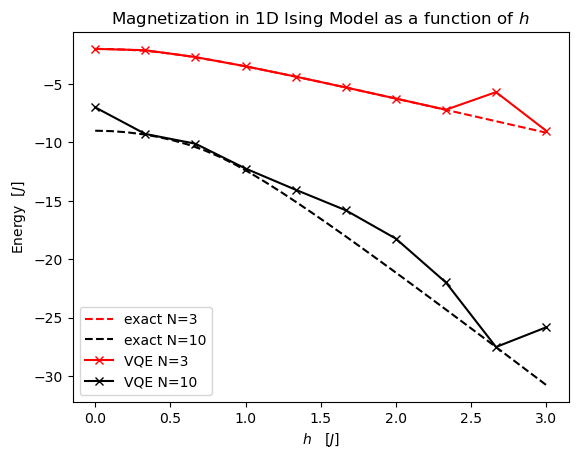

In [87]:
plt.plot(hvals, energy_exact_N3, c="red", ls="--", label="exact N=3")
plt.plot(hvals, energy_exact_N10, c="black", ls="--", label="exact N=10")
plt.plot(hvalsQu, energy_VQE_N3, c="red", marker="x", ls="-", label="VQE N=3")
plt.plot(hvalsQu, energy_VQE_N10, c="black",  marker="x", ls="-", label="VQE N=10")
plt.xlabel("$h$   $[J]$")
plt.ylabel("Energy  $[J]$")
plt.legend(loc="lower left")
plt.title("Magnetization in 1D Ising Model as a function of $h$")
plt.savefig("Energy_vs_h.png", dpi=300, bbox_inches='tight')

The above plots show that the $1D$ Ising model exhibits a quantum phase transition at $J=h$, where the magnetization jumps from $1$ to $0$. This jump gets more sudden with more lattice sites $N$. The results using the VQE are reasonably accurate, especially for low $N$. At large $N$ both the magnetization and energy differ slightly from the direct numeric result. The reason for this could be a not general enough ansatz for the ground state or inefficient minimization algorithms.